<a href="https://colab.research.google.com/github/forlinarthur/deep-learning-tensorflow/blob/master/NLP_Real_or_Not_Detection_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2

In [0]:
# Unfortunately this URL doesn't work directly with pd.read_csv
#!unzip "drive/My Drive/NLP - Real or not/nlp-getting-started.zip" -d "drive/My Drive/NLP - Real or not/"

In [0]:
df_train = pd.read_csv('drive/My Drive/NLP - Real or not/train.csv')

In [0]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df_train.keyword.fillna(value='', inplace=True)
df_train.location.fillna(value='', inplace=True)

In [0]:
df_train.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df_train.text = df_train.text.str.replace('[\,\.\'\#\!\:\;\(\)\?\@\$\/\=\>\<\[\]\|\-\_]', '', regex=True)
df_train.text = df_train.text.str.replace('[0-9]', '', regex=True)
df_train.text = df_train.text.str.replace('(http).*(\s)', '', regex=True)

In [0]:
df_train.head(10)

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this earthquake Ma...,1
1,4,,,Forest fire near La Ronge Sask Canada,1
2,5,,,All residents asked to shelter in place are be...,1
3,6,,,people receive wildfires evacuation orders in...,1
4,7,,,Just got sent this photo from Ruby Alaska as s...,1
5,8,,,RockyFire Update California Hwy closed in bo...,1
6,10,,,flood disaster Heavy rain causes flash floodin...,1
7,13,,,Im on top of the hill and I can see a fire in ...,1
8,14,,,Theres an emergency evacuation happening now i...,1
9,15,,,Im afraid that the tornado is coming to our area,1


In [0]:
filter_values = ['ablaze', 'accident', 'aftershock', '']
df_train.keyword[~df_train.keyword.isin(filter_values)][:20]

136    airplane%20accident
137    airplane%20accident
138    airplane%20accident
139    airplane%20accident
140    airplane%20accident
141    airplane%20accident
142    airplane%20accident
143    airplane%20accident
144    airplane%20accident
145    airplane%20accident
146    airplane%20accident
147    airplane%20accident
148    airplane%20accident
149    airplane%20accident
150    airplane%20accident
151    airplane%20accident
152    airplane%20accident
153    airplane%20accident
154    airplane%20accident
155    airplane%20accident
Name: keyword, dtype: object

In [0]:
df_train.keyword = df_train.keyword.str.split(pat='%20')
df_train.keyword = df_train.keyword.apply(lambda x: ' '.join(map(str, x)))

In [0]:
df_train.keyword[~df_train.keyword.isin(filter_values)][:20]

136    airplane accident
137    airplane accident
138    airplane accident
139    airplane accident
140    airplane accident
141    airplane accident
142    airplane accident
143    airplane accident
144    airplane accident
145    airplane accident
146    airplane accident
147    airplane accident
148    airplane accident
149    airplane accident
150    airplane accident
151    airplane accident
152    airplane accident
153    airplane accident
154    airplane accident
155    airplane accident
Name: keyword, dtype: object

In [0]:
df_train.location = df_train.location.str.replace('[\,\.\'\#\!\:\;\(\)\?\@\$\/\|\x89Û¢\=\>\<\[\]\|\-\_]', '', regex=True)
df_train.location = df_train.location.str.replace('[0-9]', '', regex=True)
df_train.location = df_train.location.str.replace('(http).*(\s)', '', regex=True)

In [0]:
len(df_train.location.unique())

3197

In [0]:
len(df_train.keyword.unique())

222

In [0]:
df_train.text.count()

7613

In [0]:
# df_new = pd.DataFrame({"keyword": df_train.keyword, "location": df_train.location, "text": corpus})
X = df_train[['keyword', 'location', 'text']].agg(' '.join, axis=1)
# X = df_train.text 
Y = df_train.target

In [0]:
X[100:120]

100    accident UK NorwayMFA Bahrain police had previ...
101    accident Nairobi Kenya I still have not heard ...
102    aftershock Instagram  heyimginog  afterShockDe...
103    aftershock  The man who can drive himself furt...
104    aftershock Switzerland  IR ICEMOON AFTERSHOCK ...
105    aftershock  There is no victory at bargain bas...
106    aftershock US  IR ICEMOON AFTERSHOCK  httptcoz...
107    aftershock  Nobody remembers who came in secon...
108    aftershock Instagram  heyimginog  afterShockDe...
109    aftershock  The harder the conflict the more g...
110    aftershock  GrowingUpSpoiled going clay pigeon...
111    aftershock Somewhere Only We Know  So i guess ...
112    aftershock  Aftershock was the most terrifying...
113     aftershock Belgium Aftershock httpstcoxMWODFMtUI
114    aftershock Switzerland  IR ICEMOON AFTERSHOCK ...
115    aftershock US  IR ICEMOON AFTERSHOCK  httptcoz...
116     aftershock   IR ICEMOON AFTERSHOCK  httptcoaDDOq
117    aftershock dope show KJF

In [0]:
# split up the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 18756 unique tokens.


In [0]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (6090, 35)


In [0]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1523, 35)


In [0]:
# Create the model

# We get to choose embedding dimensionality
D = 25

# Hidden state dimensionality
M = 128

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

kernel_reg = l1_l2(l1=0.0012, l2=0.0013)

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True, recurrent_dropout=0.5, kernel_regularizer=kernel_reg)(x)
x = Dropout(0.5)(x)
x = LSTM(M, recurrent_dropout=0.5)(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(M, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [0]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_delta=1E-7, verbose=1)

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01, decay=0.001), metrics=['accuracy', 'binary_crossentropy'])
model.summary()

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 35)]              0         
_________________________________________________________________
embedding_67 (Embedding)     (None, 35, 25)            468925    
_________________________________________________________________
lstm_88 (LSTM)               (None, 35, 128)           78848     
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 128)           0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 129

In [0]:
print('Training model...')
r = model.fit(data_train,
              y_train,
              epochs=20,
              shuffle=False,
              validation_data=(data_test, y_test),
              callbacks=[lr_scheduler]
    )

Training model...
Epoch 1/20
183/191 [===========================>..] - ETA: 1s - loss: 0.7387 - accuracy: 0.5606 - binary_crossentropy: 0.6894

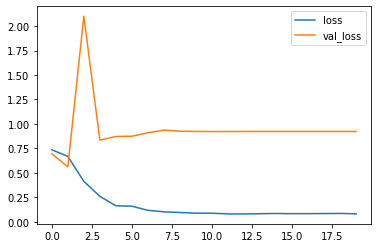

In [0]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

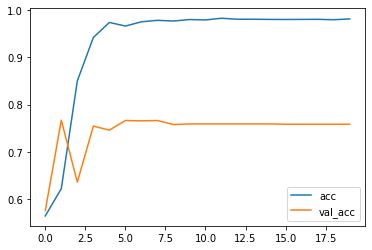

In [0]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()